# Data Challenge Submission - Casey Kongpanickul

Hi all, 
Here is my data challenge submission. I will narrarate along the way with
insights / reasoning.

The first few cells are pretty standard. Importing what I need from different
libraries, loading the data and beginning the exploratory data analysis.

Since the direction of the challenge is pretty open, I will spend some time looking at different aspects of the dataset before cleaning it up and honing in on the problem I want to solve.

tl;dr

Saturday morning I had a article pop-up on my news feed which helped picked 
the direction of the analysis.  

https://www.businessinsider.com/san-francisco-poop-patrol-employees-make-184000-a-year-2018-8

In [1]:
import pandas as pd
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import seaborn as sns


%matplotlib inline



In [2]:
df = pd.read_csv("C:/Users/Casey/Documents/Apple_challenge/data/311_cases.csv")
df.head()

C:\Users\Casey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
0,241459,07/02/2008 03:16:55 PM,07/12/2010 10:16:59 AM,07/12/2010 10:16:59 AM,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,Lifted_sidewalk_tree_roots,Intersection of RETIRO WAY and RICO WAY,2.0,Marina,NORTHERN,37.80493,-122.4381,"(37.8049295544814, -122.438141782293)",Phone,NaN
1,241538,07/02/2008 04:47:08 PM,06/25/2010 11:16:56 AM,06/25/2010 11:16:56 AM,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Damaged_Tree,Hanging_limb,Intersection of ELLIS ST and WEBSTER ST,5.0,Western Addition,NORTHERN,37.78257,-122.4308,"(37.7825698284387, -122.430797788991)",Phone,NaN
2,241571,07/02/2008 05:54:07 PM,10/21/2010 12:09:32 PM,10/21/2010 12:09:32 PM,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Overgrown_Tree,Blocking_street_lights,"4228 GEARY BLVD, SAN FRANCISCO, CA, 94118",1.0,Inner Richmond,RICHMOND,37.78120,-122.4650,"(37.7812, -122.465)",Phone,NaN
3,241909,07/03/2008 12:38:04 PM,06/25/2010 11:16:56 AM,06/25/2010 11:16:56 AM,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Landscaping,Sprinkler_system_issues,Intersection of 29TH ST and DOLORES ST,8.0,Noe Valley,INGLESIDE,37.74384,-122.4244,"(37.743838109851, -122.424384904295)",Phone,NaN
4,241917,07/03/2008 12:44:26 PM,07/06/2010 06:16:58 PM,07/06/2010 06:16:58 PM,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of BRANNAN ST and DELANCEY ST,6.0,South Beach,SOUTHERN,37.78361,-122.3898,"(37.7836091422541, -122.389846394555)",Phone,NaN


In [3]:
df['Opened'] = pd.to_datetime(df['Opened'])
df['Closed'] = pd.to_datetime(df['Closed'])
df['Updated'] = pd.to_datetime(df['Updated'])

In [4]:
df['Opened'].describe()

count                 3129761
unique                2894792
top       2018-05-20 00:19:00
freq                       26
first     2008-07-01 00:13:13
last      2018-08-22 00:53:00
Name: Opened, dtype: object

## Initial Data Structuring and Exploration
The following is some helpful date setup for EDA, and a little bit of feature creation. From the datetime I extract a few features
that I plan on using later.

In [5]:
df['Year'] = df['Opened'].dt.year
df['Month'] = df['Opened'].dt.month
df['year_month'] = df['Opened'].apply(lambda x: date(year=x.year, month=x.month, day=1))
df['Day'] = df['Opened'].dt.weekday
df['Delta'] = df['Closed'] - df['Opened']
df['Day'].unique()

array([2, 3, 0, 1, 4, 5, 6], dtype=int64)

In [6]:
df.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,...,Latitude,Longitude,Point,Source,Media URL,Year,Month,year_month,Day,Delta
0,241459,2008-07-02 15:16:55,2010-07-12 10:16:59,2010-07-12 10:16:59,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Damaging_Property,Lifted_sidewalk_tree_roots,...,37.80493,-122.4381,"(37.8049295544814, -122.438141782293)",Phone,NaN,2008,7,2008-07-01,2,739 days 19:00:04
1,241538,2008-07-02 16:47:08,2010-06-25 11:16:56,2010-06-25 11:16:56,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Damaged_Tree,Hanging_limb,...,37.78257,-122.4308,"(37.7825698284387, -122.430797788991)",Phone,NaN,2008,7,2008-07-01,2,722 days 18:29:48
2,241571,2008-07-02 17:54:07,2010-10-21 12:09:32,2010-10-21 12:09:32,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Overgrown_Tree,Blocking_street_lights,...,37.78120,-122.4650,"(37.7812, -122.465)",Phone,NaN,2008,7,2008-07-01,2,840 days 18:15:25
3,241909,2008-07-03 12:38:04,2010-06-25 11:16:56,2010-06-25 11:16:56,Closed,NaN,DPW Ops Queue,Tree Maintenance,Trees - Landscaping,Sprinkler_system_issues,...,37.74384,-122.4244,"(37.743838109851, -122.424384904295)",Phone,NaN,2008,7,2008-07-01,3,721 days 22:38:52
4,241917,2008-07-03 12:44:26,2010-07-06 18:16:58,2010-07-06 18:16:58,Closed,NaN,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,...,37.78361,-122.3898,"(37.7836091422541, -122.389846394555)",Phone,NaN,2008,7,2008-07-01,3,733 days 05:32:32


In [7]:
neigh_counts = df['Neighborhood'].value_counts().reset_index(name="counts")
print(df['Neighborhood'].unique())
print(neigh_counts.head())

['Marina' 'Western Addition' 'Inner Richmond' 'Noe Valley' 'South Beach'
 nan 'Silver Terrace' 'South of Market' 'Presidio Terrace'
 'Corona Heights' 'Buena Vista' 'Outer Richmond' 'Mission'
 'Diamond Heights' 'Eureka Valley' 'Cole Valley' "St. Mary's Park"
 'Holly Park' 'Financial District' 'Haight Ashbury' 'Glen Park' 'Portola'
 'Outer Sunset' 'Mission Terrace' 'Miraloma Park' 'Lake Street'
 'Visitacion Valley' ' ' 'Central Waterfront' 'Mission Dolores'
 'Presidio Heights' 'Lower Pacific Heights' 'Excelsior' 'Treasure Island'
 'Castro' 'Dolores Heights' 'Pacific Heights' 'Golden Gate Park'
 'Inner Sunset' 'Japantown' 'Parkmerced' 'Lone Mountain' 'Upper Market'
 'Hayes Valley' 'Laguna Honda' 'North Beach' 'Crocker Amazon' 'Cow Hollow'
 'Parkside' 'Bayview' 'Duboce Triangle' 'Hunters Point' 'Showplace Square'
 'Bernal Heights' 'Tenderloin' 'Lower Nob Hill' 'Nob Hill'
 'Golden Gate Heights' 'Sunnyside' 'University Mound' 'Civic Center'
 'Lakeshore' 'Parnassus Heights' 'Russian Hill' 'Mi

## Initial EDA Plots

In the coming cells I wanted to start getting an idea of how the data looks 
visually to help get an idea of what kind of problem to tackle for this 
challenge.

<BarContainer object of 10 artists>

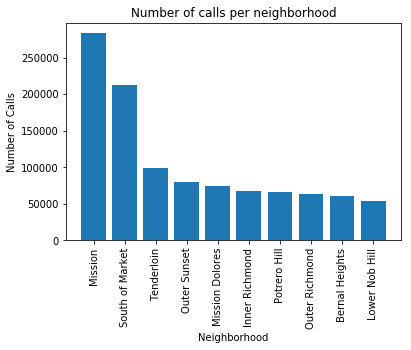

In [8]:
neigh_index = np.arange(10)
neigh_fig, neigh_ax = plt.subplots()

neigh_ax.set_xlabel('Neighborhood')
neigh_ax.set_ylabel('Number of Calls')
neigh_ax.set_title('Number of calls per neighborhood')
neigh_labels = (neigh_counts['index'])
neigh_ax.set_xticks(neigh_index)
neigh_ax.set_xticklabels(neigh_labels, rotation='vertical')

neigh_freq = neigh_ax.bar(neigh_index, neigh_counts['counts'][:10])
neigh_freq

In [9]:
type_counts = df['Request Type'].value_counts().reset_index(name="counts")
print(type_counts.head())
print(len(df['Request Type'].unique()))

                 index  counts
0          Bulky Items  393571
1     General Cleaning  369746
2  request_for_service  123517
3   Encampment Reports  118080
4          Human Waste  113217
1222


Here we notice the trend in the calls coming in over time. Before 2013 the calls were relatively steady in frequency and as time goes on we can see the trend growing at a non-linear rate. This may mean that not all of the data is needed to train models based on temporal targets if we want them to generalize well. However it will take more than this bar chart to assume that.

<BarContainer object of 9 artists>

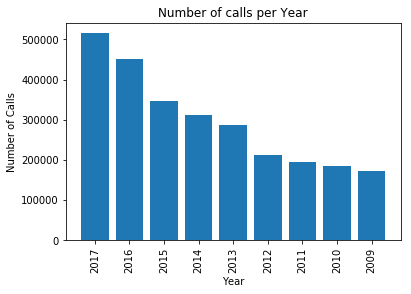

In [10]:
year_counts = df['Year'].value_counts().reset_index(name="counts")
year_count_dropped = year_counts.drop([2, 10])

year_index = np.arange(9)
year_fig, year_ax = plt.subplots()

year_ax.set_xlabel('Year')
year_ax.set_ylabel('Number of Calls')
year_ax.set_title('Number of calls per Year')
year_labels = (year_count_dropped['index'])
year_ax.set_xticks(year_index)
year_ax.set_xticklabels(year_labels, rotation='vertical')

year_freq = year_ax.bar(year_index, year_count_dropped['counts'])
year_freq

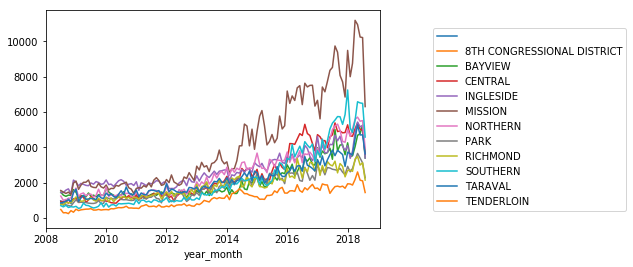

In [11]:
CallByPoliceDist = df.pivot_table(
    index='year_month', columns='Police District', 
    values='Request Type', aggfunc=len).plot().legend(loc='center right',bbox_to_anchor=(1.75, 0.5))
CallByPoliceDist

Here we can visually see some trends in the months with many of the years showing local peaks and valleys in similar months.

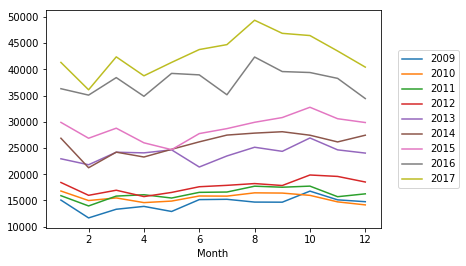

In [12]:
df_dropped = df[df.Year != 2018]
df_dropped_again = df_dropped[df_dropped.Year != 2008]
CallsByMonth = df_dropped_again.pivot_table(
    index='Month', columns='Year', 
    values='Request Type', aggfunc=len
    ).plot().legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
CallsByMonth

### Problem Formation

In the following cells I start to zero in on the issue I want to tackle
which is the Human Waste problem.

A very useful target would be to predict the "Delta" or the time it will take to process a human waste request. This would inform callers over the phone if their request would be processed "quickly" (defined as Delta < 48 or within 2 days) or if it's going to take a while (defined as Delta > 48 or greater than 2 days).


In [13]:
GroupedHomeless = df.groupby('Category')['Delta']
Mean = GroupedHomeless.apply(lambda x: np.mean(x))
AvgHomelessTime = Mean['Homeless Concerns']

GroupedWaste = df.groupby('Request Type')['Delta']
MeanWaste = GroupedWaste.apply(lambda x: np.mean(x))
AvgWasteTime = MeanWaste['Human Waste']

print(df[df['Request Type'] == "Human Waste"].describe())
print(df['Category'].value_counts().head())
print(AvgHomelessTime)
print(AvgWasteTime)

             CaseID  Supervisor District       Latitude      Longitude  \
count  1.132170e+05        111687.000000  113217.000000  113217.000000   
mean   4.933921e+06             6.369443      37.288140    -120.845321   
std    2.854382e+06             2.107802       4.255175      13.789500   
min    2.402370e+05            -1.000000       0.000000    -141.218800   
25%    2.396957e+06             6.000000      37.765250    -122.420000   
50%    5.288521e+06             6.000000      37.778210    -122.414800   
75%    7.222571e+06             8.000000      37.783990    -122.410400   
max    9.434843e+06            11.000000      37.823620       0.000000   

                Year          Month            Day                    Delta  
count  113217.000000  113217.000000  113217.000000                   111192  
mean     2014.659548       6.449402       2.655405   6 days 06:20:05.899048  
std         2.757711       3.322328       1.926995  36 days 03:21:22.295480  
min      2008.000000 

Interestingly, we can see that the volume for waste calls is growing at an alarming rate compared to years prior to 2013.

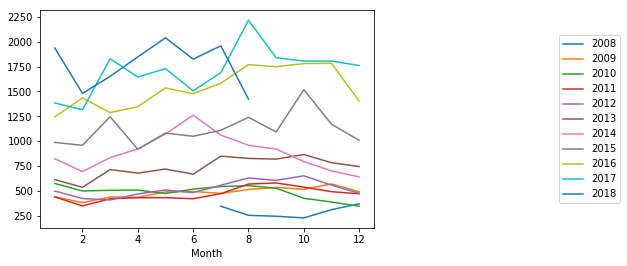

In [14]:
BioWaste = df[df['Request Type'] == 'Human Waste']
Completed = BioWaste[BioWaste['Status'] == 'Closed']

WasteFreqYear = Completed.pivot_table(
    index='Month', columns='Year', 
    values='Request Type', aggfunc=len
    ).plot().legend(loc='center right', bbox_to_anchor=(1.75, 0.5))
WasteFreqYear

At this point I want to begin cleaning the dataframe I want to work with and get it ready to be run through an algorithm. I begin with checking out the null values in the dataframe at this point and beginning to drop unnecessary features such as "CaseID". I also want to make sure that the rows with null values are not a significant portion of the dataframe. In which case it may be worth it to try and impute values for the null cells rather than drop the rows. This does not appear to be the case and I drop the values.

In [15]:
print(len(Completed))
print(Completed.isnull().any())

111192
CaseID                 False
Opened                 False
Closed                 False
Updated                False
Status                 False
Status Notes            True
Responsible Agency     False
Category               False
Request Type           False
Request Details        False
Address                False
Supervisor District     True
Neighborhood            True
Police District         True
Latitude               False
Longitude              False
Point                   True
Source                 False
Media URL               True
Year                   False
Month                  False
year_month             False
Day                    False
Delta                  False
dtype: bool


In [16]:
RandFor = Completed.drop(['CaseID', 'Status', 'Status Notes', 'Category',
                          'Request Type', 'Request Details', 'Address', 'Point',
                          'Media URL'], axis=1)
print(RandFor.isnull().any())
print(RandFor.isnull().sum())
print(len(RandFor))
RandFor = RandFor.dropna(how='any')
print(len(RandFor), "Length after dropping null values.")

RandFor['Responsible Agency'] = RandFor['Responsible Agency'].astype(str)
RandFor['Neighborhood'] = RandFor['Neighborhood'].astype(str)
RandFor['Police District'] = RandFor['Police District'].astype(str)
RandFor['Source'] = RandFor['Source'].astype(str)

le = preprocessing.LabelEncoder()
RandFor['Responsible Agency'] = le.fit_transform(RandFor['Responsible Agency'])
RandFor['Neighborhood'] = le.fit_transform(RandFor['Neighborhood'])
RandFor['Police District'] = le.fit_transform(RandFor['Police District'])
RandFor['Source'] = le.fit_transform(RandFor['Source'])
RandFor['Delta'] = RandFor['Delta'] / np.timedelta64(1, 'h')


Opened                 False
Closed                 False
Updated                False
Responsible Agency     False
Supervisor District     True
Neighborhood            True
Police District         True
Latitude               False
Longitude              False
Source                 False
Year                   False
Month                  False
year_month             False
Day                    False
Delta                  False
dtype: bool
Opened                    0
Closed                    0
Updated                   0
Responsible Agency        0
Supervisor District    1521
Neighborhood           2512
Police District        1540
Latitude                  0
Longitude                 0
Source                    0
Year                      0
Month                     0
year_month                0
Day                       0
Delta                     0
dtype: int64
111192
108605 Length after dropping null values.


In [17]:
RandFor.head()

,Opened,Closed,Updated,Responsible Agency,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Year,Month,year_month,Day,Delta
232,2008-12-30 10:20:51,2008-12-30 19:07:07,2008-12-30 19:07:07,14,9.0,65,3,37.75093,-122.4134,3,2008,12,2008-12-01,1,8.771111
244,2008-12-30 10:06:28,2008-12-30 11:07:07,2008-12-30 11:07:07,14,2.0,92,1,37.80336,-122.4183,3,2008,12,2008-12-01,1,1.010833
307,2008-12-29 22:45:54,2008-12-30 06:07:17,2008-12-30 06:07:17,14,6.0,98,7,37.77457,-122.4126,5,2008,12,2008-12-01,0,7.356389
335,2008-12-29 17:32:46,2008-12-30 06:07:13,2008-12-30 06:07:13,14,2.0,108,4,37.79704,-122.4349,3,2008,12,2008-12-01,0,12.574167
352,2008-12-29 16:47:56,2008-12-30 06:07:12,2008-12-30 06:07:12,14,11.0,29,2,37.71678,-122.4406,3,2008,12,2008-12-01,0,13.321111


Here I begin the process that will complete the grooming process for this dataframe before splitting it and learning a model

In [18]:
RandForComp = RandFor.drop(['Opened','Closed', 'Updated',
                                'year_month'], axis=1)
RandForComp.head()

,Responsible Agency,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Year,Month,Day,Delta
232,14,9.0,65,3,37.75093,-122.4134,3,2008,12,1,8.771111
244,14,2.0,92,1,37.80336,-122.4183,3,2008,12,1,1.010833
307,14,6.0,98,7,37.77457,-122.4126,5,2008,12,0,7.356389
335,14,2.0,108,4,37.79704,-122.4349,3,2008,12,0,12.574167
352,14,11.0,29,2,37.71678,-122.4406,3,2008,12,0,13.321111


### Target/ Data Validation 

As I start to pick apart this problem I notice that some of the time deltas
are negative which is a red flag. In the next few cells I investiage where this
is coming from and ultimately decide to reject rows with negative deltas


In [19]:
RandForComp['Delta'].describe()

count    108605.000000
mean        148.684253
std         852.709246
min        -166.411111
25%           9.227778
50%          28.041389
75%          89.766111
max       42165.912500
Name: Delta, dtype: float64

In [20]:
NegTime = RandForComp[RandForComp['Delta'] < 0]
NegTime.describe()

,Responsible Agency,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Year,Month,Day,Delta
count,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000,4114.000000
mean,14.025036,6.219981,80.148760,6.150219,37.774606,-122.421125,2.926835,2014.724842,8.080700,2.546184,-6.573805
std,0.705372,1.955617,31.990832,2.963477,0.121831,0.293365,1.242823,1.284341,2.086461,1.813296,7.207123
min,14.000000,-1.000000,1.000000,0.000000,30.009900,-141.218800,1.000000,2014.000000,2.000000,0.000000,-166.411111
25%,14.000000,6.000000,65.000000,3.000000,37.770187,-122.419300,3.000000,2014.000000,6.000000,1.000000,-8.230972
50%,14.000000,6.000000,98.000000,7.000000,37.781785,-122.415000,3.000000,2014.000000,9.000000,2.000000,-6.033333
75%,14.000000,6.000000,106.000000,9.000000,37.784230,-122.411600,3.000000,2014.000000,10.000000,4.000000,-3.983333
max,36.000000,11.000000,115.000000,9.000000,37.807960,-122.386200,5.000000,2017.000000,12.000000,6.000000,-0.002222


In [21]:
NegTime['Police District'].value_counts()

9    1749
3     779
7     620
1     309
4     267
5     161
2      88
0      65
6      41
8      35
Name: Police District, dtype: int64

In [22]:
NegTime['Supervisor District'].value_counts()

 6.0     2393
 9.0      521
 3.0      340
 8.0      256
 5.0      179
 10.0     175
 2.0      154
 1.0       35
 11.0      27
 7.0       21
 4.0       11
-1.0        2
Name: Supervisor District, dtype: int64

In [23]:
NegTime['Source'].value_counts()

3    2479
1     879
5     701
4      55
Name: Source, dtype: int64

In [24]:
NegTime['Year'].value_counts()

2014    3120
2017     994
Name: Year, dtype: int64

In [25]:
NegTime['Responsible Agency'].value_counts()

14    4108
36       4
22       1
21       1
Name: Responsible Agency, dtype: int64

In [26]:
NegTime['Month'].value_counts()

10    879
9     767
6     602
5     518
7     464
8     379
11    289
12    129
4      83
3       2
2       2
Name: Month, dtype: int64

Upon further inspection the time deltas also have an extremely large side as
well. 42165 Hours is is about 1756 days. A lot of the entries may have been 
failed to be closed. I am going to make the assertion here that anything over 2
weeks (336 hours) is a mistake and will be rejected as valid data

In [27]:
RandForComp= RandForComp[RandForComp['Delta'] > 0]
print(RandForComp['Delta'].describe())

RandForComp = RandForComp[RandForComp['Delta'] < 336]
print(RandForComp['Delta'].describe())

count    104491.000000
mean        154.797044
std         868.764992
min           0.001389
25%          12.423056
50%          29.970556
75%          93.104028
max       42165.912500
Name: Delta, dtype: float64
count    96418.000000
mean        51.832773
std         61.206000
min          0.001389
25%         10.161875
50%         26.551667
75%         72.480694
max        335.933333
Name: Delta, dtype: float64


The dataframe has been cleaned up a lot at this point and I begin to encode 
the categorical variables to feed into an algorithm. The following cells 
show the final parameters used for the algorithms and some analysis.

In [28]:
RandForComp = pd.get_dummies(data=RandForComp,
                             columns=['Responsible Agency', 'Neighborhood',
                                      'Police District', 'Source'])


In [29]:
RandForComp['Target'] = round(RandForComp['Delta'])
RandForComp['Target'] = (RandForComp['Target'] < 48).astype(int)
labels = np.array(RandForComp['Target'])
RandForComp.drop(['Target', 'Delta'], axis=1, inplace=True)

feature_list = list(RandForComp.columns)

features = np.array(RandForComp)

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size = 0.25,
                                                    random_state = 100)

print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (72313, 176)
Training Labels Shape: (72313,)
Testing Features Shape: (24105, 176)
Testing Labels Shape: (24105,)


In [285]:
rf = RandomForestClassifier(n_estimators = 1000,
                            random_state = 42, max_depth=17, min_samples_leaf=5)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [286]:
predictions = rf.predict(X_test)
print("Accuracy is ", accuracy_score(y_test,predictions))

Accuracy is  0.6588259697158266


### Model Validation

Accuracy is not a great metric for a binary classification problem with skewed class distributions, so in the next few 
cells I take a closer look at the score distribution and the ROC curve.

[[  692  7883]
 [  341 15189]]


0.7018050045149142

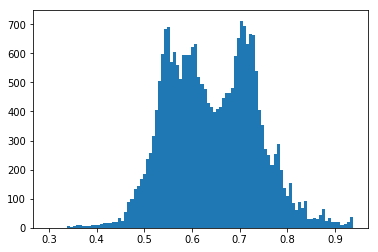

In [287]:
pred_probs = rf.predict_proba(X_test)[:,1]
ProbDistHist = plt.hist(pred_probs, bins=100)
ProbDistHist
print(confusion_matrix(y_test, predictions))
AUC = roc_auc_score(y_test, pred_probs)
AUC

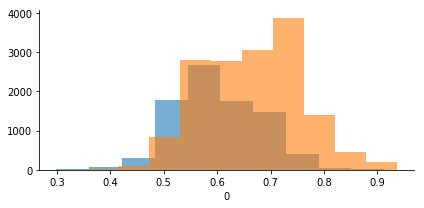

In [288]:
PredDF = pd.DataFrame(pred_probs)
PredDF['true_class'] = y_test
PredDF.head()

g = sns.FacetGrid(PredDF, hue='true_class', size=3, aspect=2, sharex='none')
_ = g.map(plt.hist, 0, alpha=0.6)

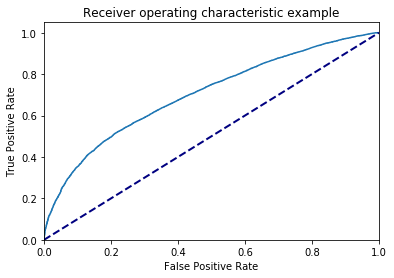

In [289]:
fpr, tpr, _ = roc_curve(PredDF.iloc[:,1], PredDF.iloc[:,0])

plt.figure()
lw = 2
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

The final step before moving on is to run the model on the training data and check the confusion matrix for over-fitting. To combat over-fitting in random forest I could tweak the min leaf samples hyper parameter as well as tuning the max depth of the tree.

In [290]:
predictionsTrain = rf.predict(X_train)
print("Accuracy is ", accuracy_score(y_train,predictionsTrain))
print(confusion_matrix(y_train, predictionsTrain))

Accuracy is  0.670280585786788
[[ 2688 23229]
 [  614 45782]]


### Train-test Temporal Split

Finally for completion I did two temporal splits on the data
and followed a similar process. Ultimately, this will be the preferred method to learn a model for this type of problem because we want the model to attempt to generalize well to data that is coming in chronologically and not randomly mixed.

In [176]:
CompletedTS = Completed.copy()
CompletedTS = Completed.drop(['CaseID', 'Status', 'Status Notes', 'Category',
                          'Request Type', 'Request Details', 'Address', 'Point',
                          'Media URL'], axis=1)
print(CompletedTS.isnull().any())
print(CompletedTS.isnull().sum())
print(len(CompletedTS))
CompletedTS = CompletedTS.dropna(how='any')
print(len(CompletedTS), "Length after dropping null values.")

CompletedTS['Responsible Agency'] = CompletedTS['Responsible Agency'].astype(str)
CompletedTS['Neighborhood'] = CompletedTS['Neighborhood'].astype(str)
CompletedTS['Police District'] = CompletedTS['Police District'].astype(str)
CompletedTS['Source'] = CompletedTS['Source'].astype(str)

le = preprocessing.LabelEncoder()
CompletedTS['Responsible Agency'] = le.fit_transform(CompletedTS['Responsible Agency'])
CompletedTS['Neighborhood'] = le.fit_transform(CompletedTS['Neighborhood'])
CompletedTS['Police District'] = le.fit_transform(CompletedTS['Police District'])
CompletedTS['Source'] = le.fit_transform(CompletedTS['Source'])
CompletedTS['Delta'] = CompletedTS['Delta'] / np.timedelta64(1, 'h')

Opened                 False
Closed                 False
Updated                False
Responsible Agency     False
Supervisor District     True
Neighborhood            True
Police District         True
Latitude               False
Longitude              False
Source                 False
Year                   False
Month                  False
year_month             False
Day                    False
Delta                  False
dtype: bool
Opened                    0
Closed                    0
Updated                   0
Responsible Agency        0
Supervisor District    1521
Neighborhood           2512
Police District        1540
Latitude                  0
Longitude                 0
Source                    0
Year                      0
Month                     0
year_month                0
Day                       0
Delta                     0
dtype: int64
111192
108605 Length after dropping null values.


In [177]:
CompletedTS.head()

,Opened,Closed,Updated,Responsible Agency,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Year,Month,year_month,Day,Delta
232,2008-12-30 10:20:51,2008-12-30 19:07:07,2008-12-30 19:07:07,14,9.0,65,3,37.75093,-122.4134,3,2008,12,2008-12-01,1,8.771111
244,2008-12-30 10:06:28,2008-12-30 11:07:07,2008-12-30 11:07:07,14,2.0,92,1,37.80336,-122.4183,3,2008,12,2008-12-01,1,1.010833
307,2008-12-29 22:45:54,2008-12-30 06:07:17,2008-12-30 06:07:17,14,6.0,98,7,37.77457,-122.4126,5,2008,12,2008-12-01,0,7.356389
335,2008-12-29 17:32:46,2008-12-30 06:07:13,2008-12-30 06:07:13,14,2.0,108,4,37.79704,-122.4349,3,2008,12,2008-12-01,0,12.574167
352,2008-12-29 16:47:56,2008-12-30 06:07:12,2008-12-30 06:07:12,14,11.0,29,2,37.71678,-122.4406,3,2008,12,2008-12-01,0,13.321111


In [178]:
CompletedTS.describe()

,Responsible Agency,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Year,Month,Day,Delta
count,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000
mean,13.894544,6.375572,75.681276,5.593214,37.773586,-122.418600,2.529709,2014.663745,6.456167,2.655522,148.684253
std,2.041184,2.096643,31.572265,2.959413,0.072365,0.171787,1.261956,2.729195,3.324853,1.924930,852.709246
min,0.000000,-1.000000,0.000000,0.000000,30.009900,-141.218800,0.000000,2008.000000,1.000000,0.000000,-166.411111
25%,14.000000,6.000000,65.000000,3.000000,37.765750,-122.420100,1.000000,2013.000000,4.000000,1.000000,9.227778
50%,14.000000,6.000000,87.000000,7.000000,37.778520,-122.415000,3.000000,2015.000000,7.000000,3.000000,28.041389
75%,14.000000,8.000000,106.000000,9.000000,37.784000,-122.410700,3.000000,2017.000000,9.000000,4.000000,89.766111
max,48.000000,11.000000,116.000000,9.000000,37.823620,-122.363400,5.000000,2018.000000,12.000000,6.000000,42165.912500


In [179]:
CompletedTS.sort_values(['Opened'], inplace=True)

In [180]:
CompletedTS['Opened'].head()

58658   2008-07-01 06:09:32
58645   2008-07-01 06:56:27
58617   2008-07-01 08:37:04
58611   2008-07-01 08:42:47
58596   2008-07-01 08:59:26
Name: Opened, dtype: datetime64[ns]

In [181]:
CompletedTS.describe()

,Responsible Agency,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Source,Year,Month,Day,Delta
count,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000,108605.000000
mean,13.894544,6.375572,75.681276,5.593214,37.773586,-122.418600,2.529709,2014.663745,6.456167,2.655522,148.684253
std,2.041184,2.096643,31.572265,2.959413,0.072365,0.171787,1.261956,2.729195,3.324853,1.924930,852.709246
min,0.000000,-1.000000,0.000000,0.000000,30.009900,-141.218800,0.000000,2008.000000,1.000000,0.000000,-166.411111
25%,14.000000,6.000000,65.000000,3.000000,37.765750,-122.420100,1.000000,2013.000000,4.000000,1.000000,9.227778
50%,14.000000,6.000000,87.000000,7.000000,37.778520,-122.415000,3.000000,2015.000000,7.000000,3.000000,28.041389
75%,14.000000,8.000000,106.000000,9.000000,37.784000,-122.410700,3.000000,2017.000000,9.000000,4.000000,89.766111
max,48.000000,11.000000,116.000000,9.000000,37.823620,-122.363400,5.000000,2018.000000,12.000000,6.000000,42165.912500


In [182]:
CompletedTS= CompletedTS[CompletedTS['Delta'] > 0]
print(CompletedTS['Delta'].describe())

CompletedTS = CompletedTS[CompletedTS['Delta'] < 336]
print(CompletedTS['Delta'].describe())

count    104491.000000
mean        154.797044
std         868.764992
min           0.001389
25%          12.423056
50%          29.970556
75%          93.104028
max       42165.912500
Name: Delta, dtype: float64
count    96418.000000
mean        51.832773
std         61.206000
min          0.001389
25%         10.161875
50%         26.551667
75%         72.480694
max        335.933333
Name: Delta, dtype: float64


In [183]:
CompletedTS = pd.get_dummies(data=CompletedTS,
                             columns=['Responsible Agency', 'Neighborhood',
                                      'Police District', 'Source'])
CompletedTS.head()

,Opened,Closed,Updated,Supervisor District,Latitude,Longitude,Year,Month,year_month,Day,...,Police District_6,Police District_7,Police District_8,Police District_9,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5
58658,2008-07-01 06:09:32,2008-07-01 11:05:06,2008-07-01 11:05:06,6.0,37.77903,-122.4018,2008,7,2008-07-01,1,...,0,1,0,0,0,0,0,1,0,0
58645,2008-07-01 06:56:27,2008-07-07 06:05:12,2008-07-07 06:05:12,8.0,37.75956,-122.4304,2008,7,2008-07-01,1,...,0,0,0,0,0,0,0,1,0,0
58617,2008-07-01 08:37:04,2008-07-02 06:05:28,2008-07-02 06:05:28,6.0,37.77671,-122.4141,2008,7,2008-07-01,1,...,0,1,0,0,0,0,0,1,0,0
58611,2008-07-01 08:42:47,2008-07-06 06:05:14,2008-07-06 06:05:14,10.0,37.75510,-122.3929,2008,7,2008-07-01,1,...,0,0,0,0,0,0,0,1,0,0
58545,2008-07-01 09:56:36,2008-07-07 06:05:13,2008-07-07 06:05:13,9.0,37.76019,-122.4200,2008,7,2008-07-01,1,...,0,0,0,0,0,0,0,1,0,0


In [184]:
split_date = datetime(2017,7,21)
TestTS = CompletedTS[(pd.to_datetime(CompletedTS["Opened"]) > split_date)]
TrainTS = CompletedTS[(pd.to_datetime(CompletedTS["Opened"]) < split_date)]

In [185]:
TestTS.describe()

,Supervisor District,Latitude,Longitude,Year,Month,Day,Delta,Responsible Agency_0,Responsible Agency_1,Responsible Agency_2,...,Police District_6,Police District_7,Police District_8,Police District_9,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5
count,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,...,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000,22217.000000
mean,6.443264,37.772176,-122.417098,2017.617545,6.517937,2.744205,48.864634,0.000135,0.000585,0.029707,...,0.018454,0.257100,0.019580,0.112751,0.000180,0.646757,0.000270,0.249719,0.005716,0.097358
std,2.375574,0.016762,0.016921,0.485998,3.251873,1.945597,59.653150,0.011620,0.024183,0.169782,...,0.134590,0.437045,0.138554,0.316296,0.013417,0.477988,0.016432,0.432860,0.075392,0.296451
min,1.000000,37.708720,-122.513200,2017.000000,1.000000,0.000000,0.012778,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,37.763460,-122.421500,2017.000000,4.000000,1.000000,3.550000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,37.774390,-122.414900,2018.000000,7.000000,3.000000,25.266667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,9.000000,37.783500,-122.407700,2018.000000,9.000000,4.000000,73.666667,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,37.809170,-122.370400,2018.000000,12.000000,6.000000,335.933333,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [186]:
TrainTS.describe()

,Supervisor District,Latitude,Longitude,Year,Month,Day,Delta,Responsible Agency_0,Responsible Agency_1,Responsible Agency_2,...,Police District_6,Police District_7,Police District_8,Police District_9,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5
count,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,...,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000,74201.000000
mean,6.354402,37.773955,-122.419165,2013.836606,6.268285,2.629843,52.721483,0.000013,0.000364,0.005970,...,0.013005,0.171332,0.016213,0.360143,0.000121,0.261681,0.000013,0.627107,0.005539,0.105538
std,2.009604,0.082033,0.195723,2.535221,3.398494,1.920977,61.635938,0.003671,0.019072,0.077037,...,0.113297,0.376801,0.126294,0.480045,0.011013,0.439553,0.003671,0.483577,0.074219,0.307247
min,-1.000000,30.009900,-141.218800,2008.000000,1.000000,0.000000,0.001389,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,37.766740,-122.419900,2012.000000,3.000000,1.000000,12.581111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,37.780300,-122.415000,2015.000000,6.000000,3.000000,27.061944,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,8.000000,37.784050,-122.411000,2016.000000,9.000000,4.000000,71.903056,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,11.000000,37.823620,-122.363400,2017.000000,12.000000,6.000000,335.860833,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [187]:
year_counts_TestTS = TestTS['year_month'].value_counts().reset_index(name="counts")
year_counts_TestTS.head()

,index,counts
0,2017-08-01,2120
1,2018-05-01,1959
2,2018-07-01,1942
3,2018-01-01,1797
4,2018-04-01,1791


In [188]:
year_counts_TrainTS = TrainTS['year_month'].value_counts().reset_index(name="counts")
year_counts_TrainTS.head()

,index,counts
0,2017-03-01,1661
1,2017-05-01,1660
2,2016-11-01,1602
3,2017-04-01,1539
4,2016-10-01,1536


In [189]:
TestTS = TestTS.drop(['Opened','Closed', 'Updated',
                                'year_month'], axis=1)

TrainTS = TrainTS.drop(['Opened','Closed', 'Updated',
                                'year_month'], axis=1)

Note: that for the temporal split we want to make sure to drop the 'Year' feature because since the dataframe is split based on time the year would technically be a target leak in this case. 

In [190]:
TestTS['Target'] = round(TestTS['Delta'])
TestTS['Target'] = (TestTS['Target'] < 48).astype(int)
TestTS_y = np.array(TestTS['Target'])
TestTS.drop(['Target', 'Delta','Year'], axis=1, inplace=True)
feature_list = list(TestTS.columns)
TestTS_X = np.array(TestTS)

In [193]:
TrainTS['Target'] = round(TrainTS['Delta'])
TrainTS['Target'] = (TrainTS['Target'] < 48).astype(int)
TrainTS_y = np.array(TrainTS['Target'])
TrainTS.drop(['Target', 'Delta', 'Year'], axis=1, inplace=True)
feature_list_train = list(TrainTS.columns)
TrainTS_X = np.array(TrainTS)

In [194]:
print('Training Features Shape:', TrainTS_X.shape)
print('Training Labels Shape:', TrainTS_y.shape)
print('Testing Features Shape:', TestTS_X.shape)
print('Testing Labels Shape:', TestTS_y.shape)

Training Features Shape: (74201, 175)
Training Labels Shape: (74201,)
Testing Features Shape: (22217, 175)
Testing Labels Shape: (22217,)


In [271]:
rfTS = RandomForestClassifier(n_estimators = 1000,
                            random_state = 42, max_depth=17, min_samples_leaf=5)
rfTS.fit(TrainTS_X, TrainTS_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [272]:
predictionsTS = rfTS.predict(TestTS_X)
print("Accuracy is ", accuracy_score(TestTS_y,predictionsTS))

Accuracy is  0.6301930953774136


I notice right away that the AUC is a bit low and my first thought is that this may be due to training on years previous to 2013 where the call volumes remained relatively stead from year to year which is not the case now.

[[  144  8013]
 [  203 13857]]


0.5598166128421059

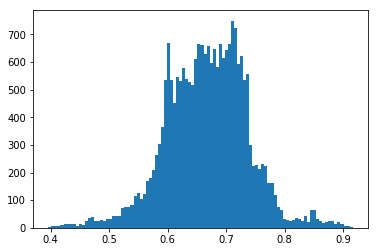

In [273]:
pred_probsTS = rfTS.predict_proba(TestTS_X)[:,1]
ProbDistHistTS = plt.hist(pred_probsTS, bins=100)
ProbDistHistTS
print(confusion_matrix(TestTS_y, predictionsTS))
AUC = roc_auc_score(TestTS_y, pred_probsTS)
AUC

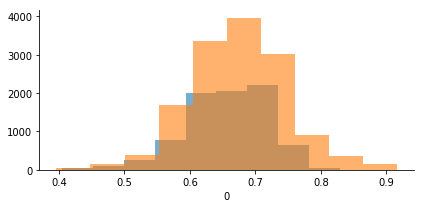

In [274]:
PredDFTS = pd.DataFrame(pred_probsTS)
PredDFTS['true_class'] = TestTS_y
PredDFTS.head()

g = sns.FacetGrid(PredDFTS, hue='true_class', size=3, aspect=2, sharex='none')
_ = g.map(plt.hist, 0, alpha=0.6)

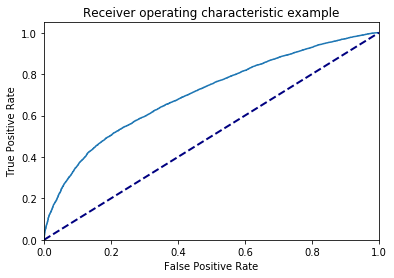

In [275]:
fprTS, tprTS, _TS = roc_curve(PredDF.iloc[:,1], PredDF.iloc[:,0])

plt.figure()
lw = 2
plt.plot(fprTS, tprTS)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [276]:
predictionsTrainTS = rfTS.predict(TrainTS_X)
print("Accuracy is ", accuracy_score(TrainTS_y,predictionsTrainTS))
print(confusion_matrix(TrainTS_y, predictionsTrainTS))

Accuracy is  0.6526731445667848
[[  751 25584]
 [  188 47678]]


As a final model for this problem I take a look at a situation where the model is only trained on more recent data.

In [201]:
TrainTSShort = CompletedTS[(pd.to_datetime(CompletedTS["Opened"]) < split_date)]
TrainTSShort = TrainTSShort[TrainTSShort['Year'] >= 2013]
TrainTSShort = TrainTSShort.drop(['Opened','Closed', 'Updated',
                                'year_month'], axis=1)

TrainTSShort.describe()

,Supervisor District,Latitude,Longitude,Year,Month,Day,Delta,Responsible Agency_0,Responsible Agency_1,Responsible Agency_2,...,Police District_6,Police District_7,Police District_8,Police District_9,Source_0,Source_1,Source_2,Source_3,Source_4,Source_5
count,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,...,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000,53052.000000
mean,6.367225,37.773241,-122.420155,2015.212094,6.037586,2.590289,46.515321,0.000019,0.000509,0.007747,...,0.014288,0.192000,0.015098,0.306661,0.000170,0.365999,0.000019,0.502733,0.006390,0.124689
std,2.075754,0.096511,0.231308,1.315075,3.359440,1.897153,58.134323,0.004342,0.022554,0.087677,...,0.118676,0.393877,0.121946,0.461112,0.013024,0.481714,0.004342,0.499997,0.079682,0.330369
min,-1.000000,30.009900,-141.218800,2013.000000,1.000000,0.000000,0.001389,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,37.766200,-122.420300,2014.000000,3.000000,1.000000,8.935556,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,37.778120,-122.415100,2015.000000,6.000000,2.000000,23.946250,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,8.000000,37.783940,-122.411000,2016.000000,9.000000,4.000000,61.818264,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,11.000000,37.823620,-122.363400,2017.000000,12.000000,6.000000,335.832222,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [202]:
TrainTSShort['Target'] = round(TrainTSShort['Delta'])
TrainTSShort['Target'] = (TrainTSShort['Target'] < 48).astype(int)
TrainTSShort_y = np.array(TrainTSShort['Target'])
TrainTSShort.drop(['Target', 'Delta', 'Year'], axis=1, inplace=True)
feature_list_train_short = list(TrainTSShort.columns)
TrainTSShort_X = np.array(TrainTSShort)

In [203]:
print('Training Features Shape:', TrainTSShort_X.shape)
print('Training Labels Shape:', TrainTSShort_y.shape)

Training Features Shape: (53052, 175)
Training Labels Shape: (53052,)


In [257]:
rfshort = RandomForestClassifier(n_estimators = 1000,
                            random_state = 42, max_depth=17, min_samples_leaf=10)
rfshort.fit(TrainTSShort_X, TrainTSShort_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [258]:
predictionsTSShort = rfshort.predict(TestTS_X)
print("Accuracy is ", accuracy_score(TestTS_y,predictionsTSShort))

Accuracy is  0.6316334338569564


There is slight improvement in this model but definitely room for more improvement

[[   92  8065]
 [  119 13941]]


0.5684455932481522

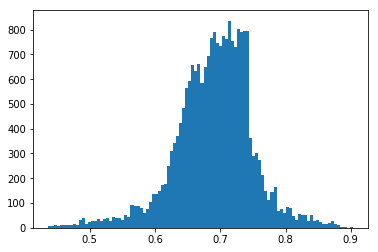

In [259]:
pred_probsTSShort = rfshort.predict_proba(TestTS_X)[:,1]
ProbDistHistTSShort = plt.hist(pred_probsTSShort, bins=100)
ProbDistHistTSShort
print(confusion_matrix(TestTS_y, predictionsTSShort))
AUCShort = roc_auc_score(TestTS_y, pred_probsTSShort)
AUCShort

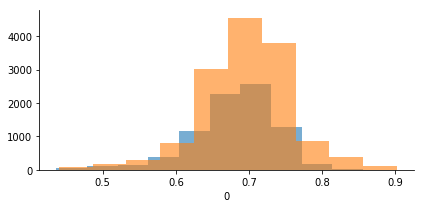

In [260]:
PredDFTSShort = pd.DataFrame(pred_probsTSShort)
PredDFTSShort['true_class'] = TestTS_y
PredDFTSShort.head()

g = sns.FacetGrid(PredDFTSShort, hue='true_class', size=3, aspect=2, sharex='none')
_ = g.map(plt.hist, 0, alpha=0.6)

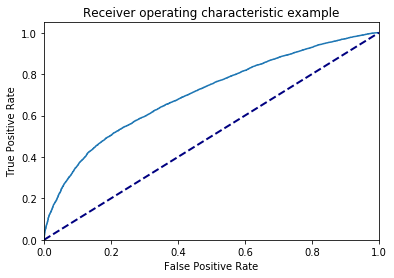

In [261]:
fprTSShort, tprTSShort, _TSShort = roc_curve(PredDF.iloc[:,1], PredDF.iloc[:,0])

plt.figure()
lw = 2
plt.plot(fprTS, tprTS)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [262]:
predictionsTrainTSShort = rfshort.predict(TrainTSShort_X)
print("Accuracy is ", accuracy_score(TrainTSShort_y,predictionsTrainTSShort))
print(confusion_matrix(TrainTSShort_y, predictionsTrainTSShort))

Accuracy is  0.6914725175299706
[[  196 16333]
 [   35 36488]]


### Sanity Checking

In the last few cells I will be sanity checking the models but looking for
1. Uniformity in any of the features (sum of 0)
2. Suspicious feature importances 

In [385]:
for column in RandForComp.columns:
    print(column, RandForComp[column].sum())

Supervisor District 614653.0
Latitude 3642049.640309975
Longitude -11803365.114699684
Year 194254099
Month 609922
Day 256105
Responsible Agency_0 4
Responsible Agency_1 40
Responsible Agency_2 1103
Responsible Agency_4 293
Responsible Agency_5 552
Responsible Agency_6 36
Responsible Agency_7 2
Responsible Agency_8 2
Responsible Agency_10 35
Responsible Agency_11 1
Responsible Agency_12 19
Responsible Agency_14 93776
Responsible Agency_15 1
Responsible Agency_16 1
Responsible Agency_17 3
Responsible Agency_18 1
Responsible Agency_19 5
Responsible Agency_21 123
Responsible Agency_22 16
Responsible Agency_23 95
Responsible Agency_26 9
Responsible Agency_27 22
Responsible Agency_29 8
Responsible Agency_30 32
Responsible Agency_31 27
Responsible Agency_32 10
Responsible Agency_33 3
Responsible Agency_34 7
Responsible Agency_35 12
Responsible Agency_36 150
Responsible Agency_37 8
Responsible Agency_38 5
Responsible Agency_40 7
Responsible Agency_41 1
Responsible Agency_42 1
Responsible Agenc

In [386]:
for column in TrainTS.columns:
    print(column, RandForComp[column].sum())

Supervisor District 614653.0
Latitude 3642049.640309975
Longitude -11803365.114699684
Year 194254099
Month 609922
Day 256105
Responsible Agency_0 4
Responsible Agency_1 40
Responsible Agency_2 1103
Responsible Agency_4 293
Responsible Agency_5 552
Responsible Agency_6 36
Responsible Agency_7 2
Responsible Agency_8 2
Responsible Agency_10 35
Responsible Agency_11 1
Responsible Agency_12 19
Responsible Agency_14 93776
Responsible Agency_15 1
Responsible Agency_16 1
Responsible Agency_17 3
Responsible Agency_18 1
Responsible Agency_19 5
Responsible Agency_21 123
Responsible Agency_22 16
Responsible Agency_23 95
Responsible Agency_26 9
Responsible Agency_27 22
Responsible Agency_29 8
Responsible Agency_30 32
Responsible Agency_31 27
Responsible Agency_32 10
Responsible Agency_33 3
Responsible Agency_34 7
Responsible Agency_35 12
Responsible Agency_36 150
Responsible Agency_37 8
Responsible Agency_38 5
Responsible Agency_40 7
Responsible Agency_41 1
Responsible Agency_42 1
Responsible Agenc

In [387]:
importances = list(rf.feature_importances_)
importances

[0.019395631570257393,
 0.13366088543497998,
 0.1198729177024896,
 0.34636135614237162,
 0.12111112263150361,
 0.0827147945326802,
 5.4347186831153582e-06,
 0.0017909635141401079,
 0.0068377001071153734,
 0.0017096320524130734,
 0.0026725375678612181,
 0.000592126144949173,
 5.1595555055568412e-05,
 4.1707806968714608e-06,
 0.00044553559945942204,
 0.0,
 0.0006466905346561735,
 0.0082760518311653045,
 1.7935441086859057e-06,
 7.2543454664263012e-05,
 0.00012001176977327693,
 5.9754345502257118e-05,
 5.8397900006523413e-05,
 0.00086004061589467311,
 5.9908329963860884e-05,
 0.00062925297666250441,
 0.00029204582360219767,
 0.00011188113723481361,
 0.00012413589576748671,
 0.00010468138695761226,
 0.00027179984284364419,
 0.00012664721149105901,
 4.401288027910892e-06,
 0.00010376077102574539,
 0.00011426730555770811,
 0.00094418229696420822,
 0.00010298890764652331,
 3.4439420463993131e-05,
 9.7057538725017161e-06,
 4.4558720512629793e-05,
 0.0,
 5.4640614317405815e-05,
 6.7833020346236

In [388]:
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances

[('Supervisor District', 0.02),
 ('Latitude', 0.13),
 ('Longitude', 0.12),
 ('Year', 0.34999999999999998),
 ('Month', 0.12),
 ('Day', 0.080000000000000002),
 ('Responsible Agency_0', 0.0),
 ('Responsible Agency_1', 0.0),
 ('Responsible Agency_2', 0.01),
 ('Responsible Agency_4', 0.0),
 ('Responsible Agency_5', 0.0),
 ('Responsible Agency_6', 0.0),
 ('Responsible Agency_7', 0.0),
 ('Responsible Agency_8', 0.0),
 ('Responsible Agency_10', 0.0),
 ('Responsible Agency_11', 0.0),
 ('Responsible Agency_12', 0.0),
 ('Responsible Agency_14', 0.01),
 ('Responsible Agency_15', 0.0),
 ('Responsible Agency_16', 0.0),
 ('Responsible Agency_17', 0.0),
 ('Responsible Agency_18', 0.0),
 ('Responsible Agency_19', 0.0),
 ('Responsible Agency_21', 0.0),
 ('Responsible Agency_22', 0.0),
 ('Responsible Agency_23', 0.0),
 ('Responsible Agency_26', 0.0),
 ('Responsible Agency_27', 0.0),
 ('Responsible Agency_29', 0.0),
 ('Responsible Agency_30', 0.0),
 ('Responsible Agency_31', 0.0),
 ('Responsible Agency_32

In [389]:
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_importances

[('Year', 0.34999999999999998),
 ('Latitude', 0.13),
 ('Longitude', 0.12),
 ('Month', 0.12),
 ('Day', 0.080000000000000002),
 ('Source_3', 0.029999999999999999),
 ('Supervisor District', 0.02),
 ('Source_5', 0.02),
 ('Responsible Agency_2', 0.01),
 ('Responsible Agency_14', 0.01),
 ('Neighborhood_87', 0.01),
 ('Police District_3', 0.01),
 ('Source_1', 0.01),
 ('Responsible Agency_0', 0.0),
 ('Responsible Agency_1', 0.0),
 ('Responsible Agency_4', 0.0),
 ('Responsible Agency_5', 0.0),
 ('Responsible Agency_6', 0.0),
 ('Responsible Agency_7', 0.0),
 ('Responsible Agency_8', 0.0),
 ('Responsible Agency_10', 0.0),
 ('Responsible Agency_11', 0.0),
 ('Responsible Agency_12', 0.0),
 ('Responsible Agency_15', 0.0),
 ('Responsible Agency_16', 0.0),
 ('Responsible Agency_17', 0.0),
 ('Responsible Agency_18', 0.0),
 ('Responsible Agency_19', 0.0),
 ('Responsible Agency_21', 0.0),
 ('Responsible Agency_22', 0.0),
 ('Responsible Agency_23', 0.0),
 ('Responsible Agency_26', 0.0),
 ('Responsible Agen

In [390]:
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Year                 Importance: 0.35
Variable: Latitude             Importance: 0.13
Variable: Longitude            Importance: 0.12
Variable: Month                Importance: 0.12
Variable: Day                  Importance: 0.08
Variable: Source_3             Importance: 0.03
Variable: Supervisor District  Importance: 0.02
Variable: Source_5             Importance: 0.02
Variable: Responsible Agency_2 Importance: 0.01
Variable: Responsible Agency_14 Importance: 0.01
Variable: Neighborhood_87      Importance: 0.01
Variable: Police District_3    Importance: 0.01
Variable: Source_1             Importance: 0.01
Variable: Responsible Agency_0 Importance: 0.0
Variable: Responsible Agency_1 Importance: 0.0
Variable: Responsible Agency_4 Importance: 0.0
Variable: Responsible Agency_5 Importance: 0.0
Variable: Responsible Agency_6 Importance: 0.0
Variable: Responsible Agency_7 Importance: 0.0
Variable: Responsible Agency_8 Importance: 0.0
Variable: Responsible Agency_10 Importance: 0.

Thanks for taking a look through this project!